# Introducción al problema

Se considera un objeto volador que se mueve en una retícula $200 \times 200$ bajo la influencia del viento. El problema consiste en llegar a la región $[155,157]\times[155,157]$ en el menor tiempo posible. Por lo tanto, definimos los estados posibles como puntos en la retícula:
 $$S = \{(a,b): 0 \leq a,b \leq 199 \}$$
 Y por cada estado, se consideran $4$ acciones posibles: moverse hacia arriba \textit{u}, hacia abajo \textit{d}, hacia la izquierda \textit{l} o a la derecha \textit{r}. Por lo tanto, para todo $s \in S$, 
    $$A(s) = \{\textit{u},\textit{d},\textit{l},\textit{r}\}$$
 Las probabilidades de transición para los puntos en el interior de la retícula, es decir estados $s = (a,b)$ para $1 < a,b < 198$, están dadas por: 

 \begin{align}
         Q( (a',b') \hspace{0.1cm} \vert \hspace{0.1cm}  s, \textit{u} ) &= \left\{ \begin{array}{lcc}
                0.3 \hspace{0.2cm} \text{ si }  a' = a, b' = b + 1
             \\  0.4 \hspace{0.2cm} \text{ si }  a' = a, b' = b + 2
             \\  0.2  \hspace{0.2cm} \text{ si }  a' = a - 1, b' = b + 2
             \\  0.1  \hspace{0.2cm} \text{ si } a' = a - 1, b' = b + 1
             \end{array}\right.\\
          Q( (a',b') \hspace{0.1cm} \vert \hspace{0.1cm}  s, \textit{d} ) &= \left\{ \begin{array}{lcc}
             0.3 \hspace{0.2cm} \text{ si } a' = a, b' = b 
             \\ 0.3 \hspace{0.2cm} \text{ si }a' = a, b' = b - 1
             \\ 0.2 \hspace{0.2cm} \text{ si } a' = a - 1, b' = b 
             \\ 0.2 \hspace{0.2cm} \text{ si } a' = a - 1, b' = b - 1
             \end{array}\right.\\
        Q( (a',b') \hspace{0.1cm} \vert \hspace{0.1cm} s, \textit{l} ) &= \left\{ \begin{array}{lcc}
             0.3 \hspace{0.2cm} \text{ si }  a' = a-1, b' = b + 1
             \\ 0.2 \hspace{0.2cm} \text{ si }a' = a-1, b' = b 
             \\ 0.3 \hspace{0.2cm} \text{ si } a' = a - 2, b' = b 
             \\ 0.2 \hspace{0.2cm} \text{ si } a' = a - 2, b' = b + 1
             \end{array}\right.\\
          Q( (a',b') \hspace{0.1cm} \vert \hspace{0.1cm}  s, \textit{r} ) &= \left\{ \begin{array}{lcc}
             0.3 \hspace{0.2cm} \text{ si }  a' = a+1, b' = b 
             \\ 0.4 \hspace{0.2cm} \text{ si } a' = a+1, b' = b +1
             \\ 0.2 \hspace{0.2cm} \text{ si } a' = a, b' = b 
             \\ 0.1 \hspace{0.2cm} \text{ si } a' = a, b' = b + 1
             \end{array}\right.
  \end{align}

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csr_matrix, lil_matrix

import matplotlib.pyplot as plt

from scipy.optimize import linprog

from numpy import array
from numpy.linalg import norm

from timeit import default_timer as timer


Inicialmente definimos una matriz 200x200x3.Esta matriz guardará en la posición (i,j,X) la recompensa r((i,j),X).


In [2]:
recompensas = np.zeros((200,200,4))

Para llenar la matriz, se deben considerar todos los casos que se revisaron en el documento.

In [3]:
#Dado un estado (x,y) la función retorna su distancia mínima 
# al cuadrado objetivo.
def minDistanciaAObjetivo(x,y):
    dis = 300
    for i in range(155,158):
        for j in range(155, 158):
            n1 = norm( array([x,y]) - array([i,j]) )
            if( n1 < dis ):
                dis = n1
    return dis

In [4]:
def recU(a,b):
    dist= minDistanciaAObjetivo(a,b)
    rta = -500
    
    #Tengo seis casos posibles: 
    if( a == 0 and b == 199 ):
        rta = -dist
    elif ( a == 0 and b == 198 ):
        rta = -minDistanciaAObjetivo(a,b+1)
    elif ( a == 0 and b < 198 ):
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -(0.4*minDistanciaAObjetivo(a,b+1) + 0.6*minDistanciaAObjetivo(a,b+2))
    elif ( a > 0 and b == 199 ):
        rta = -(0.3*minDistanciaAObjetivo(a-1,b) + 0.7*dist)
    elif( a > 0 and b == 198 ):
        rta = -(0.3*minDistanciaAObjetivo(a-1,b+1) + 0.7*minDistanciaAObjetivo(a,b+1))
    else:
        if a <= 99 and b <= 69 and b >= 49:            
            rta = -500
        else:
            rta = -(0.3*minDistanciaAObjetivo(a,b+1) + 0.4*minDistanciaAObjetivo(a,b+2) + 
                0.2*minDistanciaAObjetivo(a-1,b+2) + 0.1*minDistanciaAObjetivo(a-1,b+1))
    return rta
    

In [5]:
def recD(a,b):
    dist= minDistanciaAObjetivo(a,b)
    rta = -500
    #Tengo cuatro casos posibles:
    if( a == 0 and b == 0 ):
        rta = -dist
    elif( a == 0 and b > 0 ):
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -( 0.5*dist +  0.5* minDistanciaAObjetivo(a,b-1) )
    elif( a > 0 and b == 0 ):
        rta = -( 0.6*dist +  0.4*minDistanciaAObjetivo(a-1,b) )
    else:
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -( 0.3*dist + 0.3*minDistanciaAObjetivo(a,b-1) + 
                0.2*minDistanciaAObjetivo(a-1,b) + 0.2*minDistanciaAObjetivo(a-1,b-1))
    return rta

In [6]:
def recL(a,b):
    dist= minDistanciaAObjetivo(a,b)
    rta = -500
    #Tengo seis casos posibles:
    if( a == 0 and b == 199 ):
        rta = -dist 
    elif( a == 1 and b == 199 ):
        rta = -minDistanciaAObjetivo(a-1,b)
    elif( a > 1 and b == 199 ):
        rta = -( 0.5*minDistanciaAObjetivo(a-1,b) + 0.5*minDistanciaAObjetivo(a-2,b) )
    elif( a == 0 and b < 199 ):
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -( 0.5*dist + 0.5*minDistanciaAObjetivo(a,b+1) )
    elif( a == 1 and b < 199 ):
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -( 0.5*minDistanciaAObjetivo(a-1,b) + 0.5*minDistanciaAObjetivo(a-1,b+1) )
    else:
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -( 0.3*minDistanciaAObjetivo(a-1,b+1) + 0.3*minDistanciaAObjetivo(a-2,b) +
                0.2*minDistanciaAObjetivo(a-1,b) + 0.2*minDistanciaAObjetivo(a-2,b+1))
    return rta

In [7]:
def recR(a,b):
    dist= minDistanciaAObjetivo(a,b)
    rta = -500
    #Tengo cuatro casos posibles:
    if( a == 199 and b == 199 ):
        rta = -dist
    elif( a < 199 and b == 199 ):
        rta = -( 0.3*dist + 0.7*minDistanciaAObjetivo(a+1,b)  ) 
    elif( a == 199 and b < 199 ):
        rta = -( 0.5*dist + 0.5*minDistanciaAObjetivo(a,b+1)  )
    else:
        if a <= 99 and b <= 69 and b >= 49:
            rta = -500
        else:
            rta = -( 0.3*minDistanciaAObjetivo(a+1,b) + 0.4*minDistanciaAObjetivo(a+1,b+1) +
                0.2*dist + 0.1*minDistanciaAObjetivo(a,b+1))
    return rta

### Llenamos la matriz de recompensas.

In [8]:
#Itero sobre toda la matriz
for a in range(0,200):
    for b in range(0,200):
        #Para cada entrada de la matriz calculo las posibles recompensas
                
        #Primero considero la acción u.
        recompensas[a,b,0] = recU(a,b)

        #Ahora considero la acción d. 
        recompensas[a,b,1] = recD(a,b)

        #Ahora considero la acción l.
        recompensas[a,b,2] = recL(a,b)

        #Ahora considero la acción r.
        recompensas[a,b,3] = recR(a,b)

## Método para calcular $I - \lambda P_{d_n}$ y $r_{d_n}$
Este método calcula $I - \lambda P_{d_n}$ a partir de un arreglo $d_n$ de acciones.

Para esto utilizamos las estructuras de datos lil_matrix, pues $P_{d_n}$ será una matriz dispersa y tenemos que hacer muchas modificaciones. Ya cuando hagamos operaciones sobre esta, la convertiremos en una csr_matrix, pues es mucho más eficiente para hacer operaciones como calcular inversas o multiplicar.

In [9]:
def calculo_Pdn_y_rdn (dn, lamb):
    #Matrix a retornar. La inicializamos como la matriz identidad
    identidad = scipy.sparse.identity(40000)
    P_dn = lil_matrix(identidad)
    #Inicializamos r_dn como un arreglo de 0's.
    r_dn = np.zeros(40000)
    #Iteramos sobre todos los estados posibles para llenar por columnas la matriz
    #En P_dn vamos a guardar realmente I - lambda P_dn
    for i in range(0,200):
        for j in range (0,200):        
            accion = dn[i*200+j] 
            index = i*200+j
            
            #Para r_dn:
            r_dn[index] = recompensas[i,j,int(accion)]
            
            #Para P_dn:
            
            #Si la acción es up                 
            if( accion == 0 ):
                if ( i == 0 and j < 198 ):
                    P_dn[index,i*200+(j+1)] = - lamb*0.4
                    P_dn[index,i*200+(j+2)] = - lamb*0.6  
                elif ( i > 0 and j == 199 ):
                    P_dn[index,(i-1)*200+j] = - lamb*0.3
                    #Está en la diagonal
                    P_dn[index,index] = 1- lamb*0.7
                elif( i > 0 and j == 198 ):
                    P_dn[index,(i-1)*200+(j+1)] = - lamb*0.3
                    P_dn[index,i*200+(j+1)] = - lamb*0.7
                elif( i == 0 and i == 199 ):
                    #Está en la diagonal
                    P_dn[index,index] = 1 - lamb 
                elif ( i == 0 and j == 198 ):
                    P_dn[index,i*200+(j+1)] = - lamb
                else:
                    P_dn[index,i*200+(j+1)] = - lamb*0.3
                    P_dn[index,i*200+(j+2)] = - lamb*0.4
                    P_dn[index,(i-1)*200+(j+2)] = - lamb*0.2
                    P_dn[index,(i-1)*200+(j+1)] = - lamb*0.1
                    
            #Si la acción es down        
            elif( accion == 1 ):
                if( i == 0 and j > 0 ):
                    #Diagonal
                    P_dn[index,index] = 1- lamb*0.5
                    P_dn[index,i*200+(j-1)] = - lamb*0.5
                elif( i > 0 and j == 0 ):
                    #Diagonal
                    P_dn[index,index] = 1- lamb*0.6
                    P_dn[index,(i-1)*200+j] = - lamb*0.4
                elif( i == 0 and j == 0 ):
                    #Diagonal
                    P_dn[index,index] = 1 - lamb  
                else:
                    #Diagonal
                    P_dn[index,index] = 1- lamb*0.3
                    P_dn[index,i*200+(j-1)] = - lamb*0.3
                    P_dn[index,(i-1)*200+j] = - lamb*0.2
                    P_dn[index,(i-1)*200+(j-1)] = - lamb*0.2   
                    
            #Si la acción es left        
            elif( accion == 2 ):
                if ( i > 1 and j == 199 ):
                    P_dn[index,(i-1)*200+j] = - lamb*0.5
                    P_dn[index,(i-2)*200+j] = - lamb*0.5
                elif( i == 0 and j < 199 ):
                    #Diagonal
                    P_dn[index,index] = 1 - lamb*0.5
                    P_dn[index,i*200+(j+1)] = - lamb*0.5
                elif( i == 1 and j < 199 ):
                    P_dn[index,(i-1)*200+j] = - lamb*0.5
                    P_dn[index,(i-1)*200+(j+1)] = - lamb*0.5
                elif( i == 0 and j == 199 ):
                    #Diagonal
                    P_dn[index,index] = 1 - lamb  
                elif( i == 1 and j == 199 ):
                    P_dn[index,(i-1)*200+j] = - lamb 
                else:
                    P_dn[index,(i-1)*200+(j+1)] = - lamb*0.3
                    P_dn[index,(i-2)*200+j] = - lamb*0.3
                    P_dn[index,(i-1)*200+j] = - lamb*0.2
                    P_dn[index,(i-2)*200+(j+1)] = - lamb*0.2
                
            #Si la acción es right.    
            elif( accion == 3 ):
                if( i < 199 and j == 199 ):
                    #Diagonal
                    P_dn[index,index] = 1- lamb*0.3
                    P_dn[index,(i+1)*200+j] = - lamb*0.7
                elif( i == 199 and j < 199 ):
                    #Diagonal
                    P_dn[index,index] = 1- lamb*0.5
                    P_dn[index,i*200+(j+1)] = - lamb*0.5
                elif( i == 199 and j == 199 ):
                    #Diagonal
                    P_dn[index,index] = 1- lamb 
                else:
                    P_dn[index,(i+1)*200+j] = - lamb*0.3
                    P_dn[index,(i+1)*200+(j+1)] = - lamb*0.4
                    #Diagonal
                    P_dn[index,index] = 1 - lamb*0.2
                    P_dn[index,i*200+(j+1)] = - lamb*0.1
    return (P_dn,r_dn)

## Cálculo de $\lambda P_a$ por filas

Dado un estado $s=(i,j)$ y una acción $a$, calcula un arreglo de tamaño $|S|$ de probabilidades. 

In [10]:
def Psa (i,j,a, lamb):
    parreglo = np.zeros(40000)
    index = i*200+j
    
    #Si la acción es up                 
    if( a == 0 ):
        if ( i == 0 and j < 198 ):
            parreglo[i*200+(j+1)] = lamb*0.4
            parreglo[i*200+(j+2)] = lamb*0.6  
        elif ( i > 0 and j == 199 ):
            parreglo[(i-1)*200+j] = lamb*0.3
            #Está en la diagonal
            parreglo[index] = lamb*0.7
        elif( i > 0 and j == 198 ):
            parreglo[(i-1)*200+(j+1)] = lamb*0.3
            parreglo[i*200+(j+1)] = lamb*0.7
        elif( i == 0 and i == 199 ):
            #Está en la diagonal
            parreglo[index] = lamb*1  
        elif ( i == 0 and j == 198 ):
            parreglo[i*200+(j+1)] = lamb*1
        else:
            parreglo[i*200+(j+1)] = lamb*0.3
            parreglo[i*200+(j+2)] = lamb*0.4
            parreglo[(i-1)*200+(j+2)] = lamb*0.2
            parreglo[(i-1)*200+(j+1)] = lamb*0.1

    #Si la acción es down        
    elif( a == 1 ):
        if( i == 0 and j > 0 ):
            #Diagonal
            parreglo[index] = lamb*0.5
            parreglo[i*200+(j-1)] = lamb*0.5
        elif( i > 0 and j == 0 ):
            #Diagonal
            parreglo[index] = lamb*0.6
            parreglo[(i-1)*200+j] = lamb*0.4
        elif( i == 0 and j == 0 ):
            #Diagonal
            parreglo[index] = lamb*1   
        else:
            #Diagonal
            parreglo[index] = lamb*0.3
            parreglo[i*200+(j-1)] = lamb*0.3
            parreglo[(i-1)*200+j] = lamb*0.2
            parreglo[(i-1)*200+(j-1)] = lamb*0.2   

    #Si la acción es left        
    elif( a == 2 ):
        if ( i > 1 and j == 199 ):
            parreglo[(i-1)*200+j] = lamb*0.5
            parreglo[(i-2)*200+j] = lamb*0.5
        elif( i == 0 and j < 199 ):
            #Diagonal
            parreglo[index] = lamb*0.5
            parreglo[i*200+(j+1)] = lamb*0.5
        elif( i == 1 and j < 199 ):
            parreglo[(i-1)*200+j] = lamb*0.5
            parreglo[(i-1)*200+(j+1)] = lamb*0.5
        elif( i == 0 and j == 199 ):
            #Diagonal
            parreglo[index] = lamb*1 
        elif( i == 1 and j == 199 ):
            parreglo[(i-1)*200+j] = lamb*1
        else:
            parreglo[(i-1)*200+(j+1)] = lamb*0.3
            parreglo[(i-2)*200+j] = lamb*0.3
            parreglo[(i-1)*200+j] = lamb*0.2
            parreglo[(i-2)*200+(j+1)] = lamb*0.2

    #Si la acción es right.    
    elif( a == 3 ):
        if( i < 199 and j == 199 ):
            #Diagonal
            parreglo[index] = lamb*0.3
            parreglo[(i+1)*200+j] = lamb*0.7
        elif( i == 199 and j < 199 ):
            #Diagonal
            parreglo[index] = lamb*0.5
            parreglo[i*200+(j+1)] = lamb*0.5
        elif( i == 199 and j == 199 ):
            #Diagonal
            parreglo[index] = lamb*1
        else:
            parreglo[(i+1)*200+j] = lamb*0.3
            parreglo[(i+1)*200+(j+1)] = lamb*0.4
            #Diagonal
            parreglo[index] = lamb*0.2
            parreglo[i*200+(j+1)] = lamb*0.1
            
    return parreglo

# Ciclo principal
Inicializamos $n = 0$, $d$ como la política que siempre va hacia arriba $\textit{u}$. 
Para guardar las políticas $d_n$ como arreglos de tamaño $200 \cdot 200 = 40000$, es necesario saber a cuál estado corresponde cada entrada. Por lo tanto tenemos esta función:
$$d[k] = \text{ acción para el estado } \left( \left\lfloor \frac{k}{200} \right\rfloor , k-\left\lfloor \frac{k}{200} \right\rfloor \cdot 200  \right) $$

Y, por lo tanto, dado un estado $s=(i,j)$, la acción a tomar bajo $d_n$ sería:
$$d[i\cdot 200 + j]$$

In [92]:
from timeit import default_timer as timer

start = timer()

lamb = 0.99
#Acá se guardará d_n
d0 = np.zeros(40000)
#Acá se guardará d_n+1
dn = np.zeros(40000)
#Condición de parada
parar = False
iteraciones = 1

while( parar == False ):
    print(iteraciones)
    dn = np.zeros(40000)
    #Calculamos qué es P_dn y r_dn 
    (P_dn,r_dn) = calculo_Pdn_y_rdn(d0,lamb)
    #Pasamos P_dn a una matriz csr pues es más rápida para hacer cálculos.
    P_dn = csr_matrix(P_dn)                            
    #Quiero resolver el sistema de ecuacones (P_dn)v = r_dn.
    v_n = scipy.sparse.linalg.spsolve(P_dn,r_dn)
    
    #Cálculo de d_n+1
    #Iteramos sobre todos los estados posibles 
    for i in range(0,200):
        for j in range(0,200):
            val = np.zeros(4)
            #Itero sobre las posibles acciones
            for a in range(0,4):
                val[a] = recompensas[i,j,a] + np.dot( Psa(i,j,a,lamb) , v_n )
            valorMaximo = np.max(val)
            if( val[ int(d0[i*200+j]) ] == valorMaximo ):
                dn[i*200+j] = d0[i*200+j] 
            else:
                dn[i*200+j] = np.argmax(val)
    #Condición de parada:
    parar = (dn==d0).all()
    d0 = dn
    iteraciones += 1
    #Fin del ciclo.
print(dn)           

end = timer()
print(end - start) 


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
[3. 3. 3. ... 2. 2. 2.]
212.59049689999983


### Paso mi arreglo de decisiones a una matriz

In [93]:
decisiones = np.zeros((200,200))

for i in range(0,200):
    for j in range(0,200):           
            decisiones[i,j] = dn[i*200+j]
            

In [94]:
def visualizarD ( dn ):
    decisiones = np.zeros((200,200))

    for i in range(0,200):
        for j in range(0,200):           
                decisiones[i,j] = dn[i*200+j]
           
    decisionesDerecho = np.zeros((200,200))

    for i in range(0,200):
        for j in range(0,200):           
                decisionesDerecho[i,j] = decisiones[j,199-i]

    #print(decisionesDerecho)
    plt.imshow(decisionesDerecho, cmap='RdPu')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.colorbar(extend='both')
    plt.clim(0, 3);

    plt.show()

Lambda =  0.99


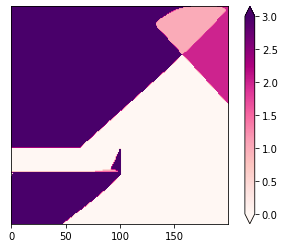

In [95]:
print("Lambda = ", lamb)
visualizarD(dn)

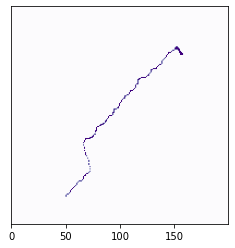

In [109]:
def simulacion (pdecisiones, a, b, color):
    recorrido = np.zeros((200,200))
    recorrido[a,b] = color
    act = a
    bct = b
    
    for index in range(0,300):
        
        #La decisión es up
        if pdecisiones[act,bct]==0:
            #Tengo seis casos posibles: 
            
            if ( act == 0 and bct < 198 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.4, 0.6])
                if eleccion == 1:
                    bct = bct + 1
                else:
                    bct = bct + 2
            elif ( act > 0 and bct == 199 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.3, 0.7])
                if eleccion == 1:
                    act= act - 1
            elif( act > 0 and bct == 198 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.3, 0.7])
                bct = bct + 1
                if eleccion == 1:
                    act = act - 1
            elif( act == 0 and bct == 199 ):
                act = act
            elif ( act == 0 and bct == 198 ):
                bct = bct + 1 
            else:
                eleccion =  np.random.choice(np.arange(1, 5), p=[0.3, 0.4, 0.2, 0.1])
                bct = bct + 1
                if eleccion == 2:
                    bct = bct + 1
                elif eleccion == 3:
                    bct = bct + 1
                    act = act - 1
                elif eleccion == 4:
                    act = act - 1
                    
        #Si la decisión es down 
        elif pdecisiones[act,bct]==1: 
            if( act == 0 and bct > 0 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.5, 0.5])
                if eleccion == 2:
                    bct = bct -1
            elif( act > 0 and bct == 0 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.6, 0.4])
                if eleccion == 2:
                    act = act - 1
            elif( act == 0 and bct == 0 ):
                act = act
            else:
                eleccion =  np.random.choice(np.arange(1, 5), p=[0.3, 0.3, 0.2, 0.2])
                if eleccion == 2:
                    bct = bct - 1
                elif eleccion == 3:
                    act = act - 1
                elif eleccion == 4:
                    bct = bct - 1
                    act = act - 1
        
        #La decisión es left
        elif pdecisiones[act,bct]==2:
            if( act == 0 and bct == 199 ):
                act = act 
            elif( act == 1 and bct == 199 ):
                act = act-1
            elif( act > 1 and bct == 199 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.5, 0.5])
                act = act - 1
                if eleccion == 2:
                    act = act - 1
            elif( act == 0 and bct < 199 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.5, 0.5])
                if eleccion == 2:
                    bct = bct + 1
            elif( act == 1 and bct < 199 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.5, 0.5])
                act = act - 1
                if eleccion == 2:
                    bct = bct + 1
            else:
                eleccion =  np.random.choice(np.arange(1, 5), p=[0.3,0.3,0.2,0.2])
                act = act - 1
                if eleccion == 1:
                    bct = bct + 1
                elif eleccion == 2:
                    act = act - 1
                elif eleccion == 4:
                    act = act - 1
                    bct = bct + 1
                
        #La decisión es right
        elif pdecisiones[act,bct]==3:
            if( act == 199 and bct == 199 ):
                act = act
            elif( act < 199 and bct == 199 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.3, 0.7])
                if eleccion == 2:
                    act = act + 1
            elif( act == 199 and bct < 199 ):
                eleccion =  np.random.choice(np.arange(1, 3), p=[0.5, 0.5])
                if eleccion == 2:
                    bct = bct + 1
            else:
                eleccion =  np.random.choice(np.arange(1, 5), p=[0.3,0.3,0.2,0.2])
                if eleccion == 1:
                    act = act + 1
                elif eleccion == 2:
                    act = act + 1
                    bct = bct + 1
                elif eleccion == 4:
                    bct = bct + 1
                    
        recorrido[act,bct] = color
        
    decisionesDerecho = np.zeros((200,200))

    for i in range(0,200):
        for j in range(0,200):           
                decisionesDerecho[i,j] = recorrido[j,199-i]

    return decisionesDerecho


plt.imshow(simulacion(decisiones, 50, 25, i+1), cmap='Purples')

plt.gca().axes.get_yaxis().set_visible(False)
plt.show()



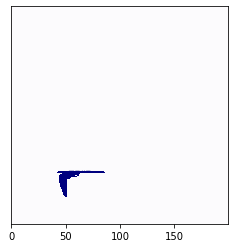

In [59]:
import matplotlib.cm as cm
fig, ax = plt.subplots()
ax.imshow(simulacion(decisiones, 50, 25, 10), cmap='Purples')

for i in range(0,100):
    sim = simulacion(decisiones, 50, 25, 10)
    masked_data = np.ma.masked_where(sim < 0.9, sim)
    ax.imshow(masked_data, cmap=cm.jet, interpolation = 'none')

plt.gca().axes.get_yaxis().set_visible(False)

plt.show()

In [146]:
simulacion(decisiones,50,25)

TypeError: simulacion() missing 1 required positional argument: 'color'

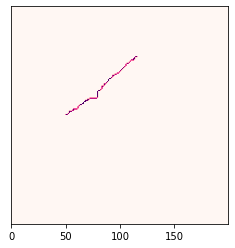

In [190]:
simulacion(decisiones,50,100)

# Problema de optimización lineal

El problema anteriormente planteado, puede ser visto como un problema de optimización lineal de la siguiente manera:

Maximizar
$$\sum_{s \in S}\alpha(s)v(s)$$
Sujeto a 
$$v(s) - \sum_{j \in S} \lambda p(j|s,a)v(j) \geq r(s,a) \hspace{0.5cm} \forall s=(x,y) \in S, \forall a \in \{u,d,l,r\} $$
$$\iff v(s)(1- \lambda p(s|s,a)) - \sum_{j \neq s} \lambda p(j|s,a)v(j) \geq r(s,a) \hspace{0.5cm} \forall s=(x,y) \in S, \forall a \in \{u,d,l,r\} $$

Las restricciones que debe cumplir la función $\alpha$ son:
$$\alpha(s) > 0  \hspace{0.5cm} \text{ y } \hspace{0.5cm} \sum_{s\in S} \alpha(s) = 1$$

Como la distribución de los estados en la cuadrícula es uniforme, utilizaremos $\alpha(s) = \frac{1}{|S|}$ para todo estado $s$, es decir
$$\alpha(s) = \frac{1}{40000}$$
Este problema se resolverá con el algoritmo Simplex.

In [16]:
lamb = 0.85
obj = 1/40000 * np.ones(40000)

#Primero agrego el lado izquierdo de las 
#desigualdades con acción up para todo estado s.
d = np.zeros(40000)
(Pd, rd) = calculo_Pdn_y_rdn(d, lamb)
lhs_ineq = csr_matrix( Pd )

for i in range(1,4):
    d = np.full(40000, i)
    (Pd, rd) = calculo_Pdn_y_rdn(d, lamb) 
    conv = csr_matrix(Pd)
    lhs_ineq = scipy.sparse.vstack( (lhs_ineq, conv) )

rhs_ineq = np.zeros(160000)
for a in range(0,4):
    for i in range(0,200):
        for j in range(0,200):
            rhs_ineq[ a*40000 + i*200 +j ] = recompensas[i,j,a]

opt = scipy.optimize.linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds = (-502,1),options={'sparse': True} )

     con: array([], dtype=float64)
     fun: -10000.124997560819
 message: 'Optimization terminated successfully.'
     nit: 13
   slack: array([1281.92506818, 1282.62729422, 1283.32724711, ..., 1441.65293584,
       1440.95445157, 1440.60302685])
  status: 0
 success: True
       x: array([-9999.99998624, -9999.99995506, -9999.99997926, ...,
       -9999.99997881, -9999.99997834, -9999.99997644])


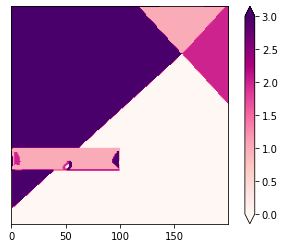

1586.4497892


In [24]:

obj = 1/(2*39997) * np.ones(40000)

obj[50*200 + 50]=1/4
obj[50*200 + 51]=1/4



opt = scipy.optimize.linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds = (-10000,2),options={'sparse': True} )
print(opt)
vn = opt.x

dn = np.zeros(40000)

#Calculamos política óptima
#Iteramos sobre todos los estados posibles 
for i in range(0,200):
    for j in range(0,200):
        val = np.zeros(4)
        #Itero sobre las posibles acciones
        for a in range(0,4):
            val[a] = recompensas[i,j,a] + np.dot( Psa(i,j,a,lamb) , vn )
        dn[i*200+j] = np.argmax(val)

visualizarD( dn )

end = timer()
print(end - start)

     con: array([], dtype=float64)
     fun: -9999.999916892793
 message: 'Optimization terminated successfully.'
     nit: 14
   slack: array([1281.92513466, 1282.62731675, 1283.32724707, ..., 1441.65291681,
       1440.95439454, 1440.60303038])
  status: 0
 success: True
       x: array([-9999.99999998, -9999.99990922, -9999.99990639, ...,
       -9999.99988527, -9999.99989656, -9999.99999998])


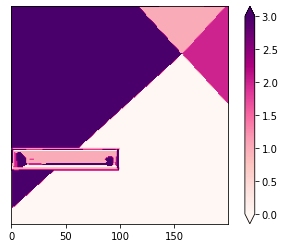

559.6155486999996


In [25]:
start = timer()

lamb = 0.85

obj = 3/(4*39998) * np.ones(40000)

obj[199*200 + 199]=1/8
obj[0]=1/8
#obj = 3/() * np.ones(40000)

#Primero agrego el lado izquierdo de las 
#desigualdades con acción up para todo estado s.
d = np.zeros(40000)
(Pd, rd) = calculo_Pdn_y_rdn(d, lamb)
lhs_ineq = csr_matrix( Pd )

for i in range(1,4):
    d = np.full(40000, i)
    (Pd, rd) = calculo_Pdn_y_rdn(d, lamb) 
    conv = csr_matrix(Pd)
    lhs_ineq = scipy.sparse.vstack( (lhs_ineq, conv) )

rhs_ineq = np.zeros(160000)
for a in range(0,4):
    for i in range(0,200):
        for j in range(0,200):
            rhs_ineq[ a*40000 + i*200 +j ] = recompensas[i,j,a]

opt = scipy.optimize.linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds = (-10000,2),options={'sparse': True} )
print(opt)
vn = opt.x

dn = np.zeros(40000)

#Calculamos política óptima
#Iteramos sobre todos los estados posibles 
for i in range(0,200):
    for j in range(0,200):
        val = np.zeros(4)
        #Itero sobre las posibles acciones
        for a in range(0,4):
            val[a] = recompensas[i,j,a] + np.dot( Psa(i,j,a,lamb) , vn )
        dn[i*200+j] = np.argmax(val)

visualizarD( dn )

end = timer()
print(end - start)


# Sensibilidad de $\lambda$

Para estudiar la sensibilidad del $\lambda$, se corrió el algoritmo de iteración por política para diferentes valores de $\lambda$.

In [128]:
start = timer()
lamb = 0.99999
#Acá se guardará d_n
d0 = np.zeros(40000)
#Acá se guardará d_n+1
dn = np.zeros(40000)
#Condición de parada
parar = False
iteraciones = 1

while( parar == False ):
    print(iteraciones)
    dn = np.zeros(40000)
    #Calculamos qué es P_dn y r_dn 
    (P_dn,r_dn) = calculo_Pdn_y_rdn(d0,lamb)
    #Pasamos P_dn a una matriz csr pues es más rápida para hacer cálculos.
    P_dn = csr_matrix(P_dn)                            
    #Quiero resolver el sistema de ecuacones (P_dn)v = r_dn.
    v_n = scipy.sparse.linalg.spsolve(P_dn,r_dn)

    #Cálculo de d_n+1
    #Iteramos sobre todos los estados posibles 
    for i in range(0,200):
        for j in range(0,200):
            val = np.zeros(4)
            #Itero sobre las posibles acciones
            for a in range(0,4):
                val[a] = recompensas[i,j,a] + np.dot( Psa(i,j,a,lamb) , v_n )
            valorMaximo = np.max(val)
            if( val[ int(d0[i*200+j]) ] == valorMaximo ):
                dn[i*200+j] = d0[i*200+j] 
            else:
                dn[i*200+j] = np.argmax(val)
    #Condición de parada:
    parar = (dn==d0).all()
    d0 = dn
    iteraciones += 1
    #Fin del ciclo.
print(dn)           
    
end = timer()
print(end - start) 

print(dn)
 


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
[0. 0. 0. ... 2. 2. 2.]
450.65143309999985
[0. 0. 0. ... 2. 2. 2.]


lambda =  0.99999


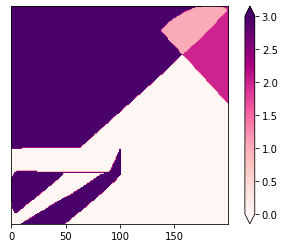

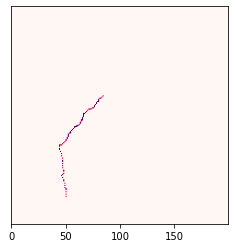

In [130]:
print("lambda = ", lamb)

visualizarD(dn)
decisiones = np.zeros((200,200))

for i in range(0,200):
    for j in range(0,200):           
            decisiones[i,j] = dn[i*200+j]

simulacion(decisiones,50,25) 

#simulacion(decisiones,50,100)

### Sensibilidad de $\lambda$

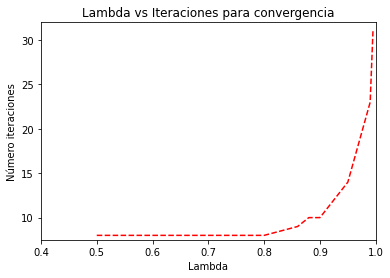

In [124]:
plt.xlabel('Lambda')
plt.ylabel('Número iteraciones')
plt.title('Lambda vs Iteraciones para convergencia')
plt.plot([0.5,0.7,0.8,0.86,0.88,0.9,0.95,0.99,0.995], [8,8,8,9,10,10,14,23,31], 'r--')
plt.axis([0.4, 1, 7.5, 32])
plt.show()

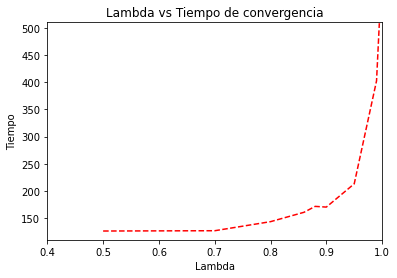

In [125]:
plt.xlabel('Lambda')
plt.ylabel('Tiempo')
plt.title('Lambda vs Tiempo de convergencia')
plt.plot([0.5,0.7,0.8,0.86,0.88,0.9,0.95,0.99,0.995], [126.16,126.70,143.37,160.60,171.48,170.18,212.99,402.47,508.49], 'r--')
plt.axis([0.4, 1, 110, 510])
plt.show()

In [ ]:
recompensas[0]